In [1]:
import numpy as np
import tensorflow as tf
import csv
import re
from tqdm import tqdm_notebook as tqdm
import nltk
import string
import random

import plot_utils as utils

In [2]:
#breaks up the sentences into lists of individual words and appends 'pos' or 'neg' after each list
posFeatures = []
negFeatures = []
all_words = []
def process(words):
    global all_words
    for word in words:
        if word.isdigit() or (word in string.punctuation):
            words.remove(word)
    words = map(string.lower, words)
    all_words.extend(words)
    return words

with open('Sentiment Analysis Dataset.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    print "start importing text data..."
    for row in tqdm(reader):
        if row['Sentiment'] == '1':
            posWords = re.findall(r"[a-zA-Z_']+", row['SentimentText'].rstrip())
            posFeatures.append(process(posWords))
        elif row['Sentiment'] == '0':
            negWords = re.findall(r"[a-zA-Z_']+", row['SentimentText'].rstrip())
            negFeatures.append(process(negWords))
    print "posFeatures size: " + str(len(posFeatures))
    print "negFeatures size: " + str(len(negFeatures))

start importing text data...



posFeatures size: 790178
negFeatures size: 788436


In [3]:
from collections import Counter
print 'start counts'
counts = Counter(all_words)

print 'sorted!!?'
vocab = sorted(counts, key=counts.get, reverse=True)

print 'create dict'
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

start counts
sorted!!?
create dict


In [4]:
pos_int = []
neg_int = []
for sent in tqdm(posFeatures):
    pos_int.append([vocab_to_int[word] for word in sent])
for sent in tqdm(negFeatures):
    neg_int.append([vocab_to_int[word] for word in sent])

del posFeatures
del negFeatures

In [5]:
pos_len = Counter([len(x) for x in pos_int])
print("Zero-length reviews: {}".format(pos_len[0]))
print("Maximum review length: {}".format(max(pos_len)))

Zero-length reviews: 0
Maximum review length: 52


In [6]:
seq_len = 50

def length_normalize(feature, seq_len):
    result = []
    for sent in tqdm(feature):
        if len(sent)<seq_len:
            # pad 0 to head
            arr= [0 for _ in range(seq_len-len(sent))]
            arr.extend(sent)
            result.append(arr)
        else:
            result.append(sent[:seq_len])
    return result

pos_input = length_normalize(pos_int, seq_len)     
neg_input = length_normalize(neg_int, seq_len)   
del pos_int
del neg_int

In [7]:
split_frac = 0.8
pos_idx = int(len(pos_input)*0.8)
neg_idx = int(len(neg_input)*0.8)

def combine_pos_neg(pos, neg):
    feature = []
    label = []
    feature.extend(pos)
    feature.extend(neg)
    label.extend([1 for i in range(len(pos))])
    label.extend([0 for i in range(len(neg))])
        
    feature_shuf = []
    label_shuf = []
    index_shuf = range(len(feature))
    random.shuffle(index_shuf)
    for i in tqdm(index_shuf):
        feature_shuf.append(feature[i])
        label_shuf.append(label[i])
    
    return np.array(feature_shuf), np.array(label_shuf)

train_pos, val_pos = pos_input[:pos_idx], pos_input[pos_idx:]
train_neg, val_neg = neg_input[:neg_idx], neg_input[neg_idx:]

train_x, train_y = combine_pos_neg(train_pos, train_neg)
val_x, val_y = combine_pos_neg(val_pos, val_neg)

del train_pos,train_neg,val_pos,val_neg

In [8]:
lstm_size = 512
lstm_layers = 1
batch_size = 500
learning_rate = 0.001

In [9]:
n_words = len(vocab)

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32,[None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32,[None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32)

In [10]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 500

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words,embed_size),-1,1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

In [11]:
with graph.as_default():
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop]* lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [12]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)

In [13]:
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)  
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [14]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [15]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [16]:
epochs = 6

train_loss = []
train_acc = []
val_loss = []
val_acc = []
with graph.as_default():
    saver = tf.train.Saver()
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        train_loss_temp = []
        train_acc_temp = []
        val_acc_temp = []
        val_loss_temp = []
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            t_acc, loss, state, _ = sess.run([accuracy, cost, final_state, optimizer], feed_dict=feed)
            train_acc_temp.append(t_acc)
            train_loss_temp.append(loss)
            if iteration%500==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
            
            if iteration%500==0:
                train_loss.append(np.mean(train_loss_temp))
                train_acc.append(np.mean(train_acc_temp))
                train_loss_temp = []
                train_acc_temp = []
                
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in tqdm(get_batches(val_x, val_y, batch_size)):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, valLoss , val_state = sess.run([accuracy, cost , final_state], feed_dict=feed)
                    val_loss_temp.append(valLoss)
                    val_acc_temp.append(batch_acc)
                
                val_loss.append(np.mean(val_loss_temp))
                val_acc.append(np.mean(val_acc_temp))
                print("Val acc: {:.3f}".format(np.mean(val_acc_temp)))
                val_loss_temp = []
                val_acc_temp=[]
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

('Epoch: 0/6', 'Iteration: 500', 'Train loss: 0.149')



Val acc: 0.801
('Epoch: 0/6', 'Iteration: 1000', 'Train loss: 0.133')



Val acc: 0.820
('Epoch: 0/6', 'Iteration: 1500', 'Train loss: 0.135')



Val acc: 0.817
('Epoch: 0/6', 'Iteration: 2000', 'Train loss: 0.122')



Val acc: 0.825
('Epoch: 0/6', 'Iteration: 2500', 'Train loss: 0.119')



Val acc: 0.830
('Epoch: 1/6', 'Iteration: 3000', 'Train loss: 0.104')



Val acc: 0.825
('Epoch: 1/6', 'Iteration: 3500', 'Train loss: 0.102')



Val acc: 0.820
('Epoch: 1/6', 'Iteration: 4000', 'Train loss: 0.080')



Val acc: 0.823
('Epoch: 1/6', 'Iteration: 4500', 'Train loss: 0.095')



Val acc: 0.816
('Epoch: 1/6', 'Iteration: 5000', 'Train loss: 0.095')



Val acc: 0.822
('Epoch: 2/6', 'Iteration: 5500', 'Train loss: 0.073')



Val acc: 0.818
('Epoch: 2/6', 'Iteration: 6000', 'Train loss: 0.062')



Val acc: 0.818
('Epoch: 2/6', 'Iteration: 6500', 'Train loss: 0.073')



Val acc: 0.815
('Epoch: 2/6', 'Iteration: 7000', 'Train loss: 0.065')



Val acc: 0.808
('Epoch: 2/6', 'Iteration: 7500', 'Train loss: 0.069')



Val acc: 0.809
('Epoch: 3/6', 'Iteration: 8000', 'Train loss: 0.043')



Val acc: 0.816
('Epoch: 3/6', 'Iteration: 8500', 'Train loss: 0.051')



Val acc: 0.812
('Epoch: 3/6', 'Iteration: 9000', 'Train loss: 0.045')



Val acc: 0.812
('Epoch: 3/6', 'Iteration: 9500', 'Train loss: 0.066')



Val acc: 0.809
('Epoch: 3/6', 'Iteration: 10000', 'Train loss: 0.042')



Val acc: 0.803
('Epoch: 4/6', 'Iteration: 10500', 'Train loss: 0.037')



Val acc: 0.811
('Epoch: 4/6', 'Iteration: 11000', 'Train loss: 0.037')



Val acc: 0.815
('Epoch: 4/6', 'Iteration: 11500', 'Train loss: 0.043')



Val acc: 0.809
('Epoch: 4/6', 'Iteration: 12000', 'Train loss: 0.041')



Val acc: 0.803
('Epoch: 4/6', 'Iteration: 12500', 'Train loss: 0.033')



Val acc: 0.807
('Epoch: 5/6', 'Iteration: 13000', 'Train loss: 0.021')



Val acc: 0.812
('Epoch: 5/6', 'Iteration: 13500', 'Train loss: 0.024')



Val acc: 0.808
('Epoch: 5/6', 'Iteration: 14000', 'Train loss: 0.021')



Val acc: 0.805
('Epoch: 5/6', 'Iteration: 14500', 'Train loss: 0.038')



Val acc: 0.806
('Epoch: 5/6', 'Iteration: 15000', 'Train loss: 0.023')



Val acc: 0.798


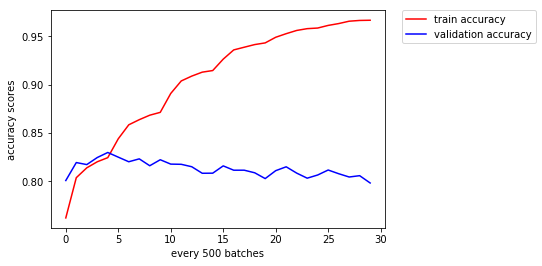

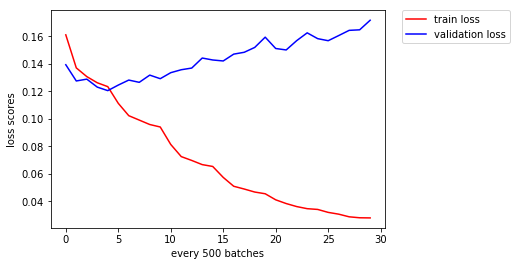

In [17]:
utils.plot_accuracy(train_acc, val_acc, 'every 500 batches')
utils.plot_loss(train_loss, val_loss , 'every 500 batches')

In [18]:
print train_acc
print val_acc
print train_loss
print val_loss

[0.762236, 0.80387598, 0.81407601, 0.82035202, 0.82461202, 0.84414321, 0.85859603, 0.86389995, 0.86854804, 0.87147999, 0.89104444, 0.90398806, 0.90899599, 0.91308802, 0.91474801, 0.92655998, 0.93609995, 0.93888801, 0.94163197, 0.94336796, 0.94919503, 0.95290798, 0.95624804, 0.95810002, 0.95874, 0.96146137, 0.963368, 0.96582001, 0.96660399, 0.96681201]
[0.80092549, 0.81952775, 0.81742632, 0.82473528, 0.82995248, 0.82512528, 0.82035816, 0.82335341, 0.81623453, 0.82244378, 0.81792074, 0.81771481, 0.81521386, 0.8084501, 0.80854195, 0.81608552, 0.811607, 0.81162286, 0.80894458, 0.80294454, 0.8111347, 0.81513464, 0.80860853, 0.80336291, 0.8066529, 0.81181306, 0.80798095, 0.80457681, 0.80594933, 0.79838353]
[0.16115181, 0.13711399, 0.13078107, 0.12629418, 0.12347648, 0.11134212, 0.10235425, 0.099146418, 0.095929101, 0.094123095, 0.081427038, 0.07259082, 0.06979049, 0.066755004, 0.065415636, 0.057458155, 0.051012587, 0.049001232, 0.046814453, 0.045557883, 0.04115377, 0.038428728, 0.036240704, 

In [19]:
print 1

1
